In [1]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [2]:
g = 1
v, Q = 1, 1
N = 256
D = 128
a = 0.125
m = 0.5
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [4]:
#
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*_boosted.npy")
fnames = glob.glob(glob_path, recursive=True)
fbt = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{m=:0.4f}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]
#
d_ex = np.load(fn_mass(fex ), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs ), allow_pickle=True).item()
d_boost = np.load(fn_mass(fbt), allow_pickle=True).item()


In [5]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)
K = Boost(N, m, g, a, ops)

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

In [6]:
fbt

['/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/ex/state_D=128_boosted.npy']

In [7]:
fns

['/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/dt=0.0625/D=128/tol=1e-06/12site/state_t=0.0000.npy',
 '/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/dt=0.0625/D=128/tol=1e-06/12site/state_t=1.0000.npy',
 '/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/dt=0.0625/D=128/tol=1e-06/12site/state_t=10.0000.npy',
 '/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/dt=0.0625/D=128/tol=1e-06/12site/state_t=11.0000.npy',
 '/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/dt=0.0625/D=128/tol=1e-06/12site/state_t=12.0000.npy',
 '/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/dt=0.0625/D=128/tol=1e-06/12site/state_t=13.0000.npy',
 '/home/marek/pdf2/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/v=1.0000/Q=1.0000/D0=128/

In [9]:
ts = np.linspace(0, 16, 17)
psi_t = {t: yastn.from_dict(np.load(fn_mass(fns, t=t), allow_pickle=True).item()['psi']) for t in ts}
chis = [x for x in d_boost['chis'] if x <= 2]
psi_chi = {chi: yastn.from_dict(d_boost['psi'][ii]) for ii, chi in enumerate(chis)}


In [14]:
probs = {}
for t, pt in psi_t.items():
    print(t)
    for chi, pc in psi_chi.items():
        if (t, chi) not in probs:
            probs[t, chi] = np.abs(mps.vdot(pt, pc)) ** 2


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0


In [ ]:
# np.save(f"probs_{m=}.npy", probs, allow_pickle=True)
# probs = np.load(f"probs_{m=}.npy", allow_pickle=True).item()

In [15]:
probs_gs = {t: np.abs(mps.vdot(pt, psi_gs)) ** 2 for t, pt in psi_t.items()}

In [ ]:
# np.save(f"probs_gs_{m=}.npy", probs_gs, allow_pickle=True)
# probs_gs = np.load(f"probs_gs_{m=}.npy", allow_pickle=True).item()


Text(0.5, 1.0, 'N=256 a=0.25')

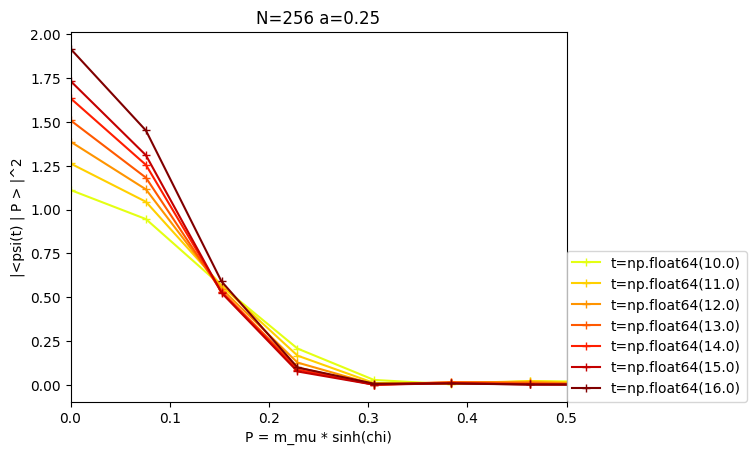

In [16]:
cm = plt.cm.jet
for t in ts[10:]:
    pr = [probs[t, chi] / probs_gs[t] for chi in chis]
    P = np.sinh(chis) * (E_ex - E_gs)
    plt.plot(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend(loc=(1, 0))
plt.xlim([0, 0.5])
#plt.ylim([1e-4, 1e2])
plt.title("N=256 a=0.25")

Text(0.5, 1.0, 'N=512 a=0.125')

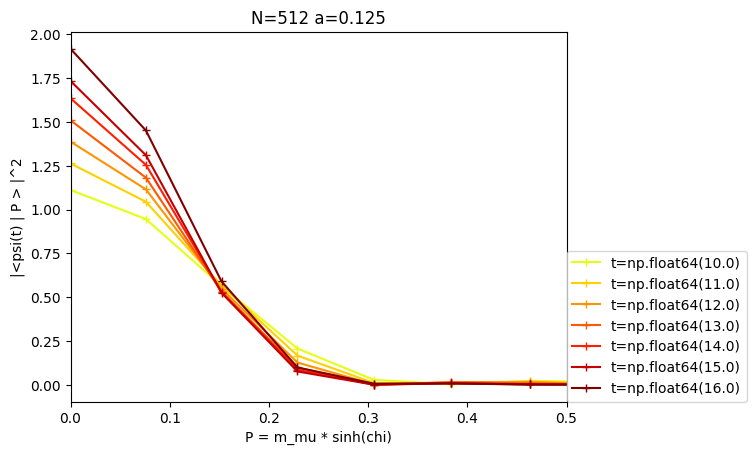

In [17]:
cm = plt.cm.jet
for t in ts[10:]:
    pr = [probs[t, chi] / probs_gs[t] for chi in chis]
    P = np.sinh(chis) * (E_ex - E_gs)
    plt.plot(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend(loc=(1, 0))
plt.xlim([0, 0.5])
#plt.ylim([1e-4, 1e2])
plt.title("N=512 a=0.125")

In [ ]:
def trace_norm(psi0, psi1, Nc = 64):
    N = psi0.N
    N2 = N // 2
    s0 = N2 - Nc // 2
    s1 = N2 + Nc // 2


    psi0 = psi0.shallow_copy()
    psi1 = psi1.shallow_copy()

    for n in range(0, N2):
        psi0.orthogonalize_site_(n=n, to='last', normalize=True)
        psi0.absorb_central_(to='last')
        psi1.orthogonalize_site_(n=n, to='last', normalize=True)
        psi1.absorb_central_(to='last')

    for n in range(N-1, N2, -1):
        psi0.orthogonalize_site_(n=n, to='first', normalize=True)
        psi0.absorb_central_(to='last')
        psi1.orthogonalize_site_(n=n, to='first', normalize=True)
        psi1.absorb_central_(to='last')

    tmp = yastn.ncon([psi0[s0], psi1[s0]], [[-0, 1, -2], [-1, 1, -3]])
    for n in range(s0+1, s1):
        tmp = yastn.ncon([tmp, psi0[n], psi1[n]], [[-0, -1, 1, 3], [1, 2, -2], [3, 2, -3]])
    return np.abs(yastn.vdot(tmp, tmp).item())


In [18]:

def exc(N, ops=None):
    from scripts_fermions.operators import S, s2i

    I, cp, cm, d = ops.I(), ops.cp(), ops.c(), ops.n()
    sites = list(range(N))
    terms =  [mps.Hterm( 1 / np.sqrt(N), [S(n + 1), S(n)], [cp, cm]) for n in sites[:-1]]
    terms += [mps.Hterm( 1 / np.sqrt(N), [S(n), S(n + 1)], [cp, cm]) for n in sites[:-1]]

    terms = [mps.Hterm(v, tuple(s2i(k) for k in p), o) for v, p, o in terms]
    H = mps.generate_mpo(I, terms, N=N)
    return H

Hex = exc(N, ops)

In [19]:
psi_ex0 = Hex @ psi_gs
psi_ex0 = psi_ex0 / psi_ex0.norm()

In [20]:
probs_2 = {}
for t, pt in psi_t.items():
    print(t)
    probs_2[t] = np.abs(mps.vdot(pt, psi_ex0)) ** 2


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0


Text(0.5, 1.0, 'N=256 a=0.125')

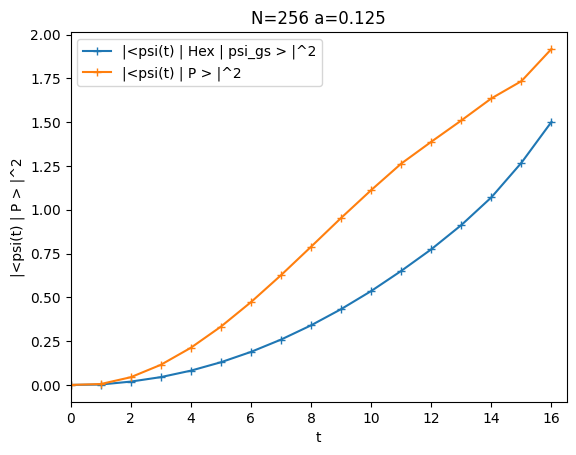

In [27]:
cm = plt.cm.jet

pr = [probs_2[t] / probs_gs[t] for t in ts]
plt.plot(ts, pr, '-+', label=f"|<psi(t) | Hex | psi_gs > |^2")

pr2 = [probs[t, 0] / probs_gs[t] for t in ts]
plt.plot(ts, pr2, '-+', label=f"|<psi(t) | P > |^2")


plt.xlabel('t')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend()
plt.xlim([0, 16.5])
#plt.ylim([1e-4, 1e2])
plt.title("N=256 a=0.125")
